# Prepare Titanic Model for Web / API

Final result on Heroku:
https://titanic-model-app.herokuapp.com/

Sources:
1. https://www.kaggle.com/c/titanic/data

2. https://towardsdatascience.com/create-an-api-to-deploy-machine-learning-models-using-flask-and-heroku-67a011800c50?gi=30b632ffd17d

2. https://blog.cambridgespark.com/deploying-a-machine-learning-model-to-the-web-725688b851c7


In [116]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>
# Align table to left

## Version Control
| Version | Date | Person | Description         
| :- |:------------- | :- | :-
|1.0 |  2/3/2020 | SW| added version control and released to production
|1.1 | 2/6/2020 | SW | added cross validation score 
|1.2 | 2/8/2020 | SW | added hyperparameter tuning for logistic

In [117]:
# last updated
from datetime import datetime
print("last updated: " + str(datetime.now()))

last updated: 2020-02-08 17:08:08.311669


## Import modules / libraries and data

In [118]:
import pandas as pd
from sklearn.linear_model import LogisticRegression # regression test
from sklearn.model_selection import GridSearchCV # for hyperparameter tuning
from sklearn.model_selection import cross_val_score # for cross validation

In [119]:
# create df,
data = pd.read_csv('titanic_train.csv')  # change file path as necessary

## Data exploration, including creating sub-training set

In [120]:
data.shape

(891, 12)

In [121]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [122]:
data.describe(include='all') 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Serepeca, Miss. Augusta",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [123]:
# see which is na
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [124]:
data = data.drop(['Name','Cabin','Embarked','Ticket'],axis = 1)
data.shape

(891, 8)

In [125]:
# one-hot coding 
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore',sparse = False)

nonNumData = data.select_dtypes(exclude = ['int64','float64'])
print(nonNumData.dtypes)

Sex    object
dtype: object


In [126]:
# transformed data is ok because we've remvoed na's
nonNumDataEncArray = enc.fit_transform(nonNumData) 
nonNumDataEnc = pd.DataFrame(data = nonNumDataEncArray)

In [127]:
# non Numeric data
print(list(nonNumDataEnc.columns))
featuresNonNumeric = ['Sex-' + str(x) for x in list(nonNumDataEnc.columns)]
print(enc.categories_)
print(featuresNonNumeric)
nonNumDataEnc.columns = featuresNonNumeric

# add new data back to dataset
data = pd.concat([data, nonNumDataEnc], axis=1)

[0, 1]
[array(['female', 'male'], dtype=object)]
['Sex-0', 'Sex-1']


## Feature selection

In [128]:
# features and target
target = 'Survived'
features = ['Pclass', 'Age', 'SibSp', 'Fare'] + featuresNonNumeric # X matrix, y vector

## Create and train model

In [129]:
# data is encoded with one-hot
train = data

In [159]:
# drop null values
train.dropna(inplace=True)

X = train[features]
y = train[target]# model 
logistic = LogisticRegression(solver='lbfgs',max_iter = 1000)

In [160]:
logistic.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [161]:
# Create regularization penalty space
penalty = ['l2']

# Create regularization hyperparameter space
C = [0.1,1,10]

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

In [167]:
#Conduct Grid Search

# Fit grid search
best_model = clf.fit(X, y)

#View Hyperparameter Values Of Best Model

# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:',  best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 0.1


In [171]:
# select model
model = LogisticRegression(C=0.1, penalty='l2', max_iter=100, solver='lbfgs')
model.fit(X,y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [172]:
scores = cross_val_score(model, X, y, cv=5)
print(type(scores))
print(scores)
print(np.mean(scores))


<class 'numpy.ndarray'>
[0.76223776 0.83216783 0.7972028  0.78321678 0.83098592]
0.8011622180636266


In [173]:
# model coefs
print(X.columns)
print(model.coef_)
print(model.intercept_)

Index(['Pclass', 'Age', 'SibSp', 'Fare', 'Sex-0', 'Sex-1'], dtype='object')
[[-0.95845322 -0.0366553  -0.30635887  0.00380772  1.05163481 -1.05163534]]
[3.06702758]


## Evaluate model

In [174]:
# score is mean accuracy
model.score(X, y)

0.803921568627451

In [176]:
# roc curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y,model.predict(X) ) # roc_curve(actual, expected)
roc_auc = auc(fpr, tpr)


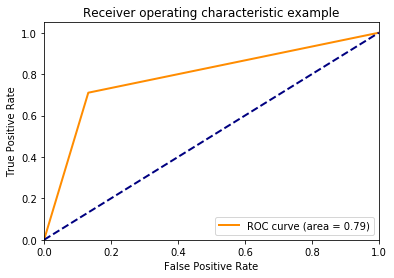

In [177]:
# plot roc curve
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Save model as pickle

In [ ]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

## Run app.py

type "python app.py" in console while in folder

## Test app web interface
Type "flask run" in terminal, once in this directory

## Test app API


In [ ]:
# local url
url = 'http://127.0.0.1:5000' 

In [ ]:
# sample data
input_sample = {'Pclass': 3
      , 'Age': 2
      , 'SibSp': 1
      , 'Fare': 50}
input_sample = json.dumps(input_sample)

In [ ]:
import requests, json

#send_request = requests.post(url, input_sample)
#print(send_request)

In [ ]:
# check actual result
#print(send_request.json())

to stop app, press ctrl+c in console

## Then create Procfile for Heroku app

## Then create requirements.txt

Use:
Flask==1.1.1
gunicorn==19.9.0
pandas==0.25.0
requests==2.22.0
scikit-learn==0.21.2
scipy==1.3.1

More generally, can do:
pip freeze > requirements.txt

## Deploy on Heroku

## Check Heroku

In [ ]:
# heroku url
heroku_url = 'https://titanic-model-app.herokuapp.com/' # change to your app name# sample data
input_sample_api = {  'Pclass': 3
             , 'Age': 2
             , 'SibSp': 1
             , 'Fare': 50}
input_sample_api = json.dumps(input_sample_api)

In [ ]:
# may need to disable firewall for this
#send_request = requests.post(heroku_url, data)
#print(send_request)

In [ ]:
#print(send_request.json())